In [1]:
# Import Dependencies
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2

In [2]:
#Load data
data_dir = 'data' 

In [3]:
#Use the Dataset API with the image_dataset_from_directory pipieline. This reduces computational load, sorts images by class and many other standard steps before image processing
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4290 files belonging to 5 classes.


## --

In [4]:
class_names = data.class_names
print(class_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


2024-08-05 15:08:10.529222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


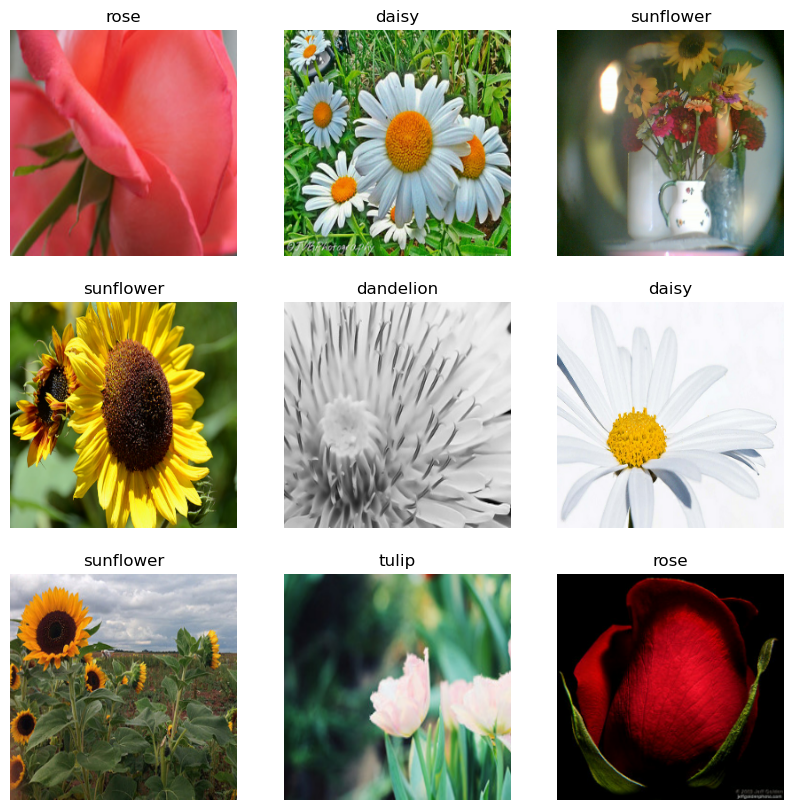

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## --

## Make a few quality checks

In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [11]:
#Check if you have two parts of this batch, one is for images and second for labels 
len(batch[0])

32

In [12]:
batch[0].shape
#Images are in default batch size of 32, reshaped to default 256 x 256 and in 3 channels, RGB. Images represented as Numpy arrays 

(32, 256, 256, 3)

In [13]:
#Have a look at the labels of the first batch
batch[1]

array([1, 1, 1, 1, 2, 1, 2, 1, 0, 3, 0, 1, 0, 2, 1, 4, 4, 3, 1, 1, 1, 1,
       1, 3, 0, 3, 0, 0, 2, 4, 2, 3], dtype=int32)

# Scale the Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [15]:
data.as_numpy_iterator().next()

(array([[[[0.99607843, 0.99607843, 0.99607843],
          [0.997549  , 0.997549  , 0.997549  ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [0.9966021 , 0.9966021 , 0.9966021 ]],
 
         [[0.996179  , 0.996179  , 0.996179  ],
          [0.99750596, 0.99750596, 0.99750596],
          [0.9998851 , 0.9998851 , 0.9998851 ],
          ...,
          [0.9998851 , 0.9998851 , 0.9998851 ],
          [0.9999569 , 0.9999569 , 0.9999569 ],
          [1.        , 1.        , 1.        ]],
 
         [[0.9995337 , 0.9995337 , 0.9995337 ],
          [0.99626994, 0.99626994, 0.99626994],
          [0.99615026, 0.99615026, 0.99615026],
          ...,
          [0.99615026, 0.99615026, 0.99615026],
          [0.9986012 , 0.9986012 , 0.9986012 ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

## Split Data 

In [16]:
len(data)

135

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [18]:
print(train_size, val_size, test_size)

94 27 14


In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Train 

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Print model layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,078,725 (225.37 MB)

 Trainable params: 59,078,725 (225.37 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=3, validation_data=val)

Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.3414 - loss: 2.0989 - val_accuracy: 0.5127 - val_loss: 1.1717
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.5507 - loss: 1.1009 - val_accuracy: 0.6169 - val_loss: 0.9624
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6189 - loss: 0.9670 - val_accuracy: 0.6343 - val_loss: 0.9143


# Plot Performance

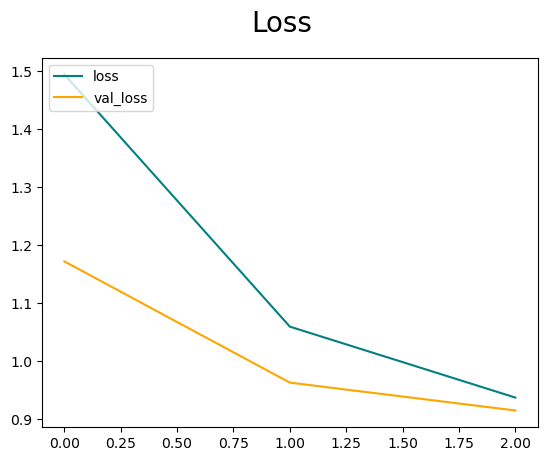

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

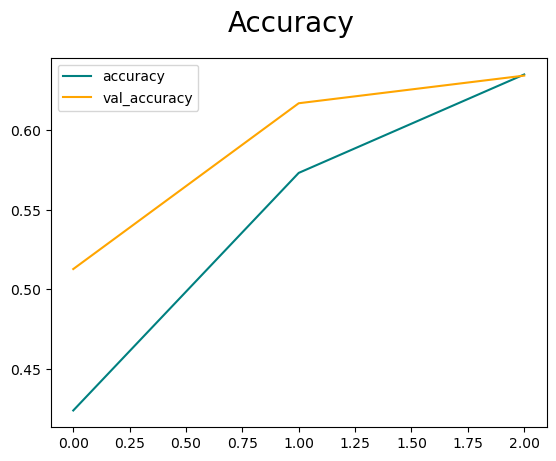

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate the model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [ ]:
test_iter = iter(test)  # Reset the dataset iterator

for batch in test_iter: 
    X, y = batch
    yhat = model.predict(X)
    
    # Convert probabilities to class predictions
    y_pred = np.argmax(yhat, axis=1)
    
    # Update metrics with class predictions
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    acc.update_state(y, y_pred)

In [ ]:
print(pre.result(), re.result(), acc.result())

In [ ]:
y.shape

In [ ]:
yhat.shape

# Test the Model

In [ ]:
img = cv2.imread('test_1.jpg')
plt.imshow(img)
plt.show()

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [ ]:
yhat

## --

In [ ]:
import requests

# Function to load and preprocess the image
def load_and_preprocess_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# URL of the image to predict
image_url = 'https://www.thetutuguru.com.au/wp-content/uploads/2020/07/Black-Madonna-Rose.jpg'

# Load and preprocess the image
img_array = load_and_preprocess_image(image_url)

# Predict the class of the image
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Get the class label
class_labels = train_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
predicted_label = class_labels[predicted_class[0]]

print(f'The predicted class is: {predicted_label}')


# Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))